## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions

In [98]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score, roc_curve, auc

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152', 'var_175', 'var_183', 'var_199']

<b> random split

In [8]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [9]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [10]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
train_dataset_scaled, scalerx = scaler(train_dataset_distance)

<b> validation_dataset is ussed as the test set

<b> sectioning:

In [11]:
train_section_1, train_section_2, train_section_3 = partitions(train_dataset_scaled)

### Cross validation using K-fold and parameter tunning

### Section 1

In [12]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
Name: mahalanobis, dtype: int64

In [13]:
def unscaler(dataset, scalerx):
    df = dataset.iloc[:,1:]
    df_unscaled = scalerx.inverse_transform(df)
    dataset_unscaled = pd.DataFrame(df_unscaled , columns = df.columns,index = df.index)
    df_result = pd.concat([dataset.iloc[:,0:1],dataset_unscaled], axis = 1)
    return df_result

In [14]:
dict_1 = {'n':3600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':2000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':3000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_1 =unscaler(train_section_1, scalerx)
train_section_1_aug = augmentation_strategy(data = unscld_train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_1
train_section_1_aug =  scaler(train_section_1_aug,scalerx)

In [15]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
2     3600
3     2000
4     3000
Name: mahalanobis, dtype: int64

In [16]:
train_section_1_aug['mahalanobis'].describe()

count    25176.000000
mean         2.709012
std          1.658208
min          1.269335
25%          1.567802
50%          2.000770
75%          3.122886
max          7.615267
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [17]:
def k_folds_indexs(data, folds = 5, balanced = False, validation_additional_false = 500, validation_reduce_false = 700 ):

    def split(a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))
    
    index = data[data.target.isin([0,1])].index
    array_index = np.array(index)
    np.random.shuffle(array_index)
    list_index = list(array_index)
    result_split = list(split(list_index, folds))
    
    result_validation_indexs = result_split
    
    if balanced:
        result_validation_indexs = list()
        for fold in result_split:
            temp_val = data[data.index.isin(fold)]
            temp_val =  balance_validation(temp_val, validation_additional_false )
            array = list(temp_val.index)
            result_validation_indexs.append(array)
    
    result_train_indexs = list()
    for fold in result_validation_indexs:
        train_data_raw = data[~data.index.isin(fold)]
        if validation_reduce_false:
            indexs = np.array(train_data_raw[train_data_raw.target.isin([0])].index)
            np.random.shuffle(indexs)
            indexs_selected = list(indexs)[0:validation_reduce_false]
        train_data_indexs = list(train_data_raw[~train_data_raw.index.isin(indexs_selected)].index)
        result_train_indexs.append(train_data_indexs)
            
    data_indexs = dict()
    for fold in range(1, folds+1):
        data_indexs[f'fold {fold}'] = { 'train index': result_train_indexs[fold-1], 'val index': result_validation_indexs[fold-1], }
    
    return data_indexs

In [18]:
kfolds_touse = k_folds_indexs(train_section_1_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 6000)

In [19]:
train_section_1_aug[train_section_1_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    6404
1    2128
2    3600
3    2000
4    3000
Name: mahalanobis, dtype: int64

In [20]:
len(train_section_1_aug[train_section_1_aug.index.isin(kfolds_touse['fold 3']['train index'])])

17132

<b> tunning strategy

In [31]:
def model_fitting_kfold(models, indexes_kfolds, features, train_data, rate_aug, sample_aug, save_model = False, save_nro_machine = 1 ):
    indexm = 1
    model_results = dict()
    model_saved = list()
    for model,rate_param, sample_param in zip(models,rate_aug, sample_aug) :
        fold_result = dict()
        fold_i = 1
        for fold in indexes_kfolds.keys():
            
            train_index, val_index = indexes_kfolds[fold]['train index'] , indexes_kfolds[fold]['val index']

            validation_data = train_data[train_data.index.isin(val_index)]
            train_data_tomodel = train_data[train_data.index.isin(train_index)]
        
            train_data_tomodel_aug = augmentation_selection_rates(train_data_tomodel, rate = rate_param, sample = sample_param)

            X_train = train_data_tomodel_aug[features]
            Y_train = train_data_tomodel_aug['target']

            X_val = validation_data[features]
            Y_val = validation_data['target']
            
            #### MODEL TRAINING:
            my_model = model.fit(X_train, Y_train)
            if save_model and indexm == save_nro_machine:
                model_saved.append(my_model)
                
            result_metrics, _, _ = metrics_train_validation(my_model, X_train, Y_train, X_val, Y_val)
            
            fold_result[f'fold-{fold_i}'] = {'metrics': result_metrics}
            #print(f'fold {fold_i} done')
            fold_i = fold_i + 1
            
        model_results[f'model-{indexm}'] = fold_result
        print(f'done machine {indexm}')
        indexm = indexm + 1
    return model_results, model_saved

In [32]:
def weighting_models(models, features, data, trained_model = None):
    X_train = data[data.target.isin([0,1])][features]
    Y_train = data[data.target.isin([0,1])]['target']
    probas_result = dict()
    i = 1
    for model in models:    
        probas = model.predict_proba(X_train)[:,1]
        probas_result[i] = probas
    probas_result['target'] = Y_train
    result_df = pd.DataFrame(probas_result)
    X_train = result_df.iloc[:,0:-1]
    Y_train = result_df['target']
    
    if trained_model:
        probas = trained_model.predict_proba(X_train)[:,1]
        return probas
    else:
        weight_model = LogisticRegression().fit(X_train, Y_train)
        return weight_model

In [40]:
#def use_weighted_model(models, features, data):

In [24]:
def jsontotable(json, typex = 'Validation'):
    list_machines, list_folds, list_acc, list_auc = list(), list(), list(),list()
    
    for machine in json.keys():
        machine_json = json[machine]
        for fold in machine_json.keys():
            mets = machine_json[fold]['metrics'][typex]
            Acc, AUC = mets['Accuracy'], mets['AUC']
            list_machines.append(machine), list_folds.append(fold), list_acc.append(Acc), list_auc.append(AUC)
    data = {'machine': list_machines, 'fold' : list_folds , 'Accuracy' : list_acc, 'AUC': list_auc}
    result_data = pd.DataFrame(data)
    return result_data

In [25]:
def plot_results(data):
    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15,10))

    ax = sns.swarmplot(ax = axs[0] , data = data , x="machine", y="AUC", hue = 'fold')
    ax = sns.swarmplot(ax = axs[1] , data = data , x="machine", y="Accuracy", hue = 'fold')

    fig.show()

In [26]:
features_to_use = numerical_features[0:4] + ['mahalanobis']

#### Section 1: SVM

In [49]:
my_svm_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'gamma' : [0.25, 0.35, 0.45, 0.15, 0.45, 0.89],
 'C' : [0.8, 0.45, 100, 1.0, 10, 1000],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    gamma_param = parameters['gamma'][i]
    c_param = parameters['C'][i]
    my_svm = svm.SVC(C = c_param, kernel = 'rbf', gamma = gamma_param, probability = True)
    my_svm_models.append(my_svm)

parameters_df = pd.DataFrame(parameters)    

In [50]:
result_tunning = model_fitting_kfold(models = my_svm_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [51]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

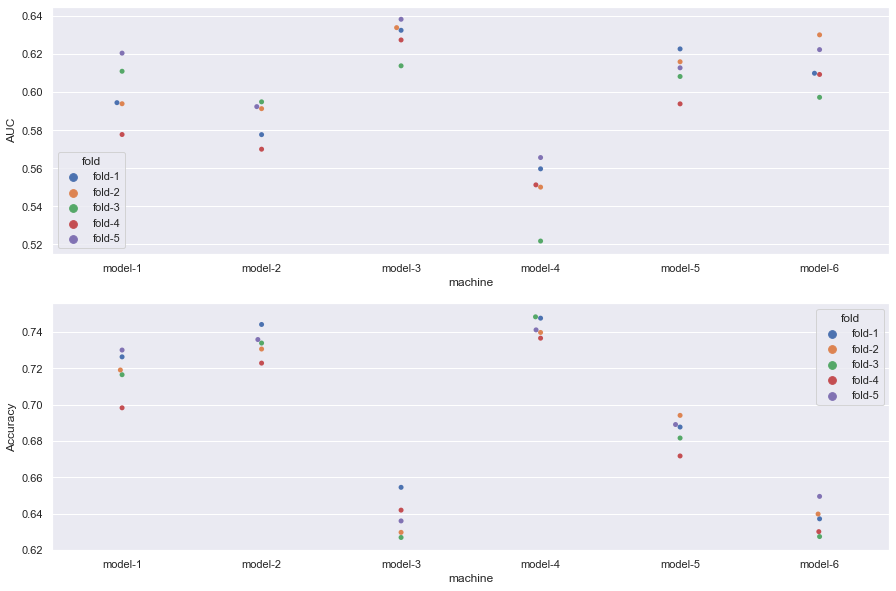

In [52]:
plot_results(toplot_result)

In [53]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,gamma,C,rate_aug,sample_aug
2,machine-3,0.45,100.0,1.0,0.9


#### Section 1: KNN

In [27]:
my_knn_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'neighbors' : [2,4,8,10,15,20],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    neighbors_param = parameters['neighbors'][i]
    my_knn = KNeighborsClassifier(n_neighbors = neighbors_param)
    my_knn_models.append(my_knn)

parameters_df = pd.DataFrame(parameters)    

In [33]:
result_tunning, modelsTrained_section_1 = model_fitting_kfold(models = my_knn_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 3)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [34]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

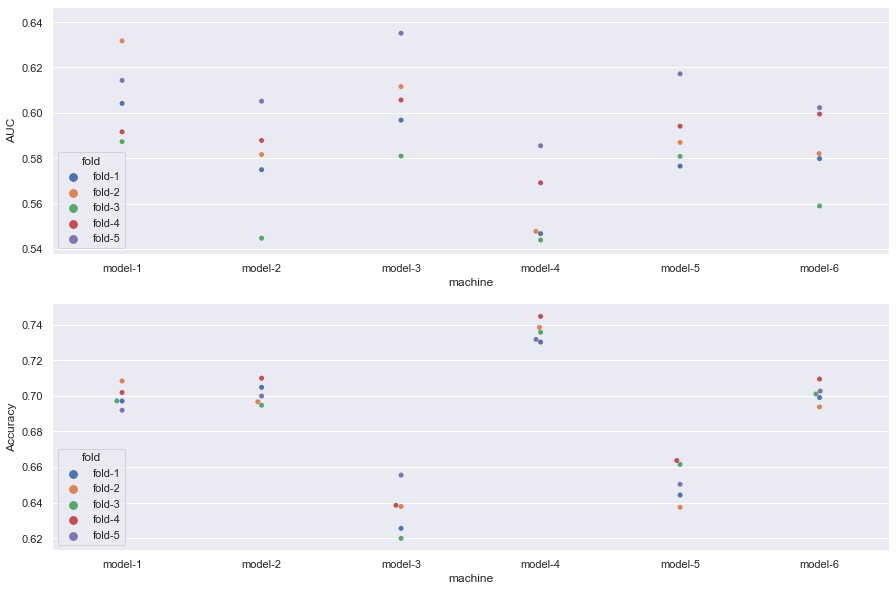

In [35]:
plot_results(toplot_result)

In [36]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,neighbors,rate_aug,sample_aug
2,machine-3,8,1.0,0.9


In [37]:
weight_data = train_section_1_aug[train_section_1_aug.target.isin([0,1])]

In [38]:
weighted_section_1_model = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data, trained_model = weighted_section_1_model)

In [39]:
roc_auc_score(weight_data.target.values,result)

0.6918736366617079

#### Section 1: Random Forest

In [59]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450],
    'max_depth' : [15, 20, 35, 20, 10, 45],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35 ], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [60]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [61]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

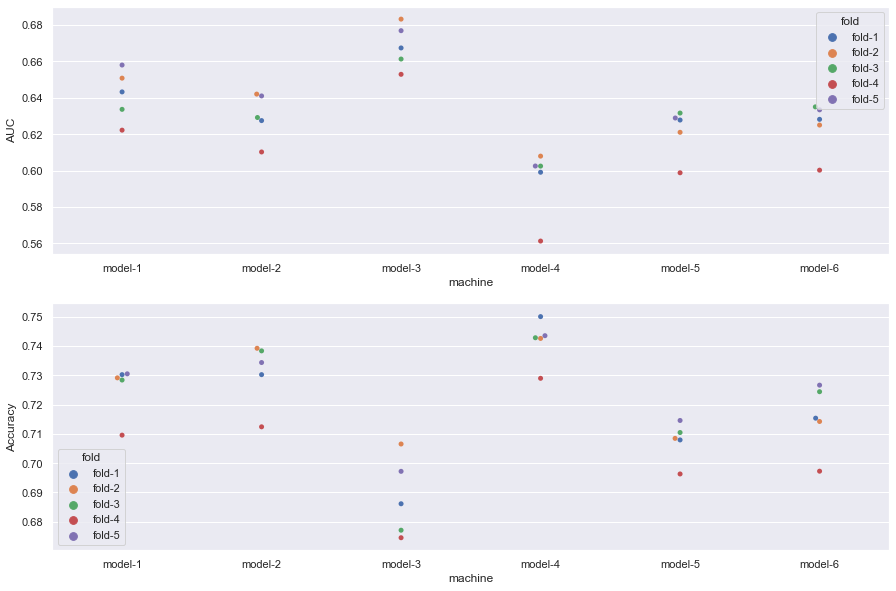

In [62]:
plot_results(toplot_result)

In [63]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.9


### Section 2

In [41]:
train_section_2.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    59759
1     7223
Name: mahalanobis, dtype: int64

In [42]:
dict_1 = {'n':6000, 'range': [9,15], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':4000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':5000, 'range': [9,15], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_2 =unscaler(train_section_2, scalerx)
train_section_2_aug = augmentation_strategy(data = unscld_train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_2
train_section_2_aug =  scaler(train_section_2_aug,scalerx)

In [43]:
train_section_2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    59759
1     7223
2     6000
3     4000
4     5000
Name: mahalanobis, dtype: int64

In [44]:
train_section_2_aug['mahalanobis'].describe()

count    81982.000000
mean         0.425127
std          0.428346
min         -0.253840
25%          0.054794
50%          0.384346
75%          0.773281
max          1.269231
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [45]:
kfolds_touse = k_folds_indexs(train_section_2_aug, folds = 5, balanced = True, validation_additional_false = 3000, validation_reduce_false = 40000)

In [46]:
train_section_2_aug[train_section_2_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    15337
1     5801
2     6000
3     4000
4     5000
Name: mahalanobis, dtype: int64

In [47]:
len(train_section_2_aug[train_section_2_aug.index.isin(kfolds_touse['fold 3']['train index'])])

36138

In [48]:
features_to_use = numerical_features[0:4] + ['mahalanobis']

#### Section 2: SVM

In [77]:
my_svm_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'gamma' : [0.25, 0.35, 0.45, 0.15, 0.45, 0.89],
 'C' : [0.8, 0.45, 1, 0.02, 0.85, 0.001],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    gamma_param = parameters['gamma'][i]
    c_param = parameters['C'][i]
    my_svm = svm.SVC(C = c_param, kernel = 'rbf', gamma = gamma_param, probability = True)
    my_svm_models.append(my_svm)

parameters_df = pd.DataFrame(parameters)    

In [78]:
result_tunning = model_fitting_kfold(models = my_svm_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [79]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

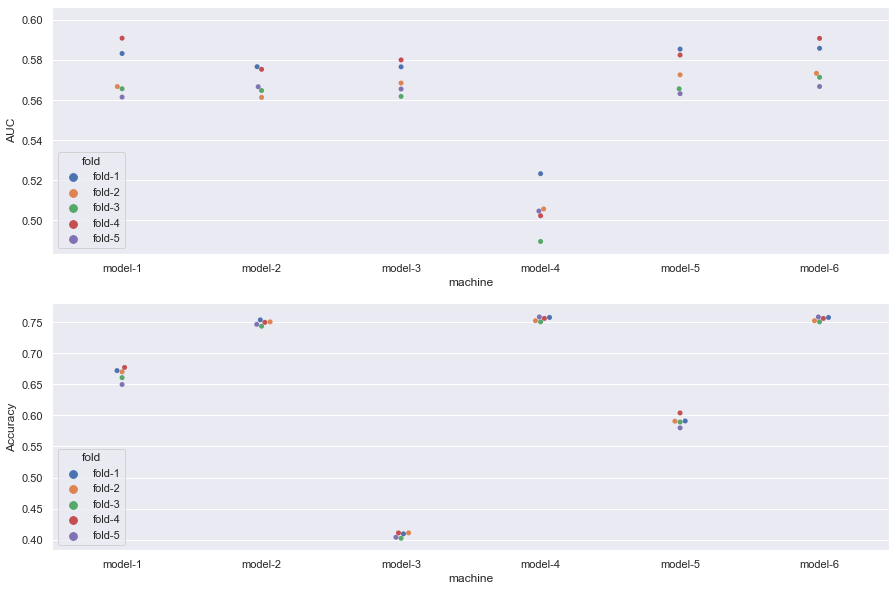

In [80]:
plot_results(toplot_result)

In [81]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,gamma,C,rate_aug,sample_aug
2,machine-3,0.45,1.0,1.0,0.7


#### Section 2: KNN

In [51]:
my_knn_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'neighbors' : [2,4,8,10,15,20],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    neighbors_param = parameters['neighbors'][i]
    my_knn = KNeighborsClassifier(n_neighbors = neighbors_param)
    my_knn_models.append(my_knn)

parameters_df = pd.DataFrame(parameters)    

In [52]:
result_tunning, modelsTrained_section_2 = model_fitting_kfold(models = my_knn_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 3)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [53]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

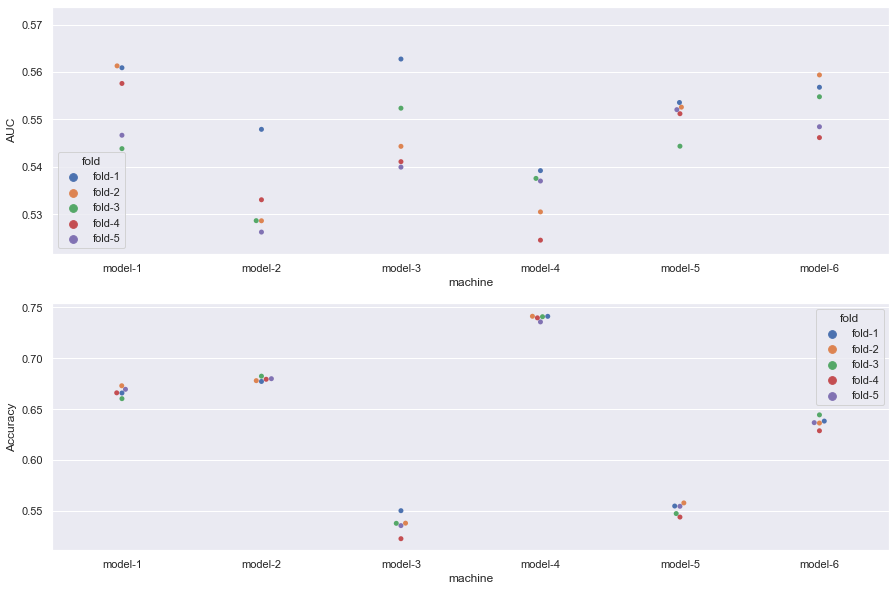

In [54]:
plot_results(toplot_result)

In [55]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,neighbors,rate_aug,sample_aug
2,machine-3,8,1.0,0.7


In [56]:
weight_data = train_section_2_aug[train_section_2_aug.target.isin([0,1])]

In [57]:
weighted_section_2_model = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = weight_data, trained_model = weighted_section_2_model)

In [58]:
roc_auc_score(weight_data.target.values,result)

0.6083402812455494

#### Section 2: Random Forest

In [87]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450],
    'max_depth' : [15, 20, 35, 20, 10, 45],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35 ], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [88]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [89]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

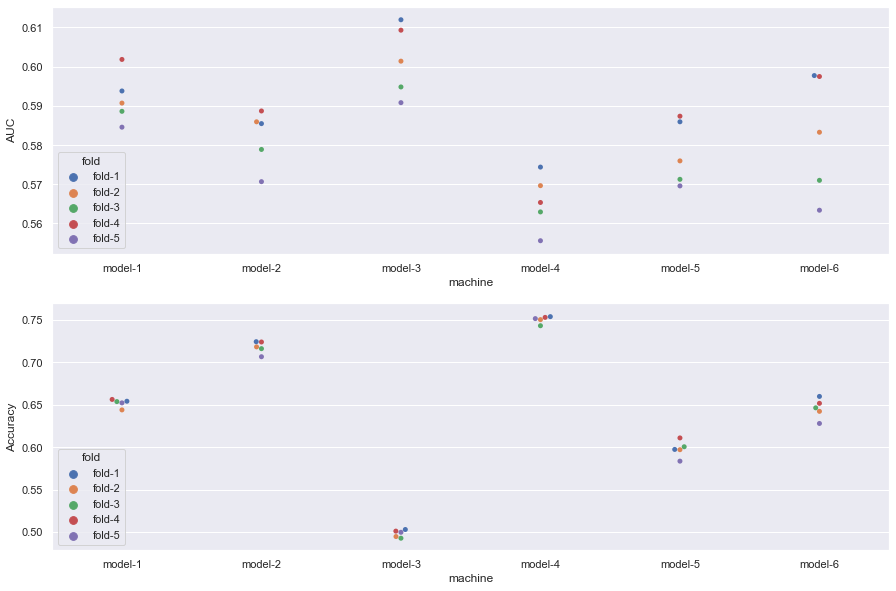

In [90]:
plot_results(toplot_result)

In [91]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.7


### Section 3

In [59]:
train_section_3.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    61175
1     5267
Name: mahalanobis, dtype: int64

In [60]:
dict_1 = {'n':6600, 'range': [-50,9], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':4800, 'label': 1} # augmetation on existing ones
dict_3 = {'n':4800, 'range': [-50,9], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_3 =unscaler(train_section_3, scalerx)
train_section_3_aug = augmentation_strategy(data = unscld_train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_3
train_section_3_aug =  scaler(train_section_3_aug,scalerx)

In [61]:
train_section_3_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    61175
1     5267
2     6600
3     4800
4     4800
Name: mahalanobis, dtype: int64

In [62]:
train_section_3_aug['mahalanobis'].describe()

count    82642.000000
mean        -0.854619
std          0.413112
min         -2.453032
25%         -1.137052
50%         -0.790699
75%         -0.513052
max         -0.253848
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [63]:
kfolds_touse = k_folds_indexs(train_section_3_aug, folds = 5, balanced = True, validation_additional_false = 3000, validation_reduce_false = 40000)

In [64]:
train_section_3_aug[train_section_3_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    17075
1     4167
2     6600
3     4800
4     4800
Name: mahalanobis, dtype: int64

In [65]:
len(train_section_3_aug[train_section_3_aug.index.isin(kfolds_touse['fold 3']['train index'])])

37442

In [66]:
features_to_use = numerical_features[0:4] + ['mahalanobis']

#### Section 3: SVM

In [104]:
my_svm_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'gamma' : [0.25, 0.35, 0.45, 0.15, 0.45, 0.89],
 'C' : [0.8, 0.45, 1, 0.02, 0.85, 0.001],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    gamma_param = parameters['gamma'][i]
    c_param = parameters['C'][i]
    my_svm = svm.SVC(C = c_param, kernel = 'rbf', gamma = gamma_param, probability = True)
    my_svm_models.append(my_svm)

parameters_df = pd.DataFrame(parameters)    

In [105]:
result_tunning = model_fitting_kfold(models = my_svm_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [106]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

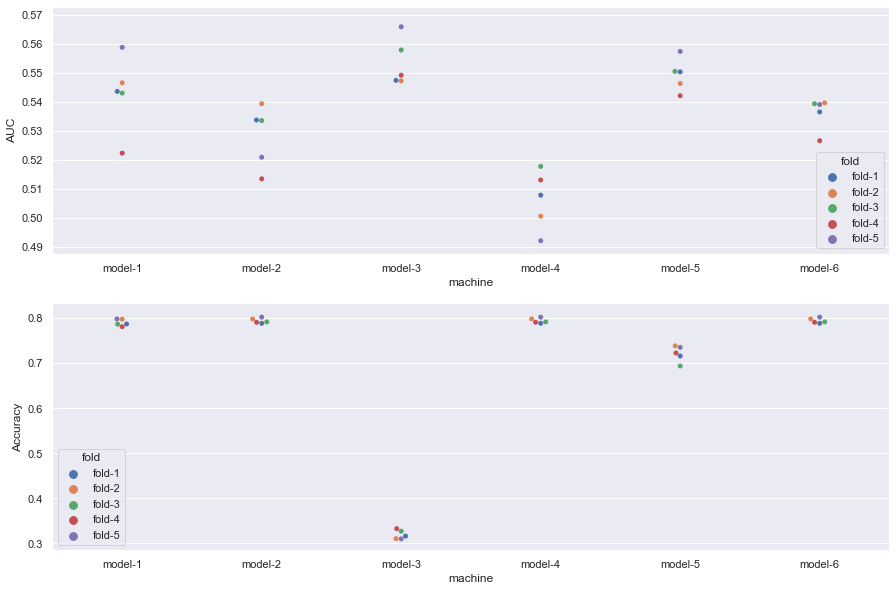

In [107]:
plot_results(toplot_result)

In [108]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,gamma,C,rate_aug,sample_aug
2,machine-3,0.45,1.0,1.0,0.7


#### Section 3: KNN

In [67]:
my_knn_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'neighbors' : [2,4,8,10,15,20],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    neighbors_param = parameters['neighbors'][i]
    my_knn = KNeighborsClassifier(n_neighbors = neighbors_param)
    my_knn_models.append(my_knn)

parameters_df = pd.DataFrame(parameters)    

In [68]:
result_tunning, modelsTrained_section_3 = model_fitting_kfold(models = my_knn_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [69]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

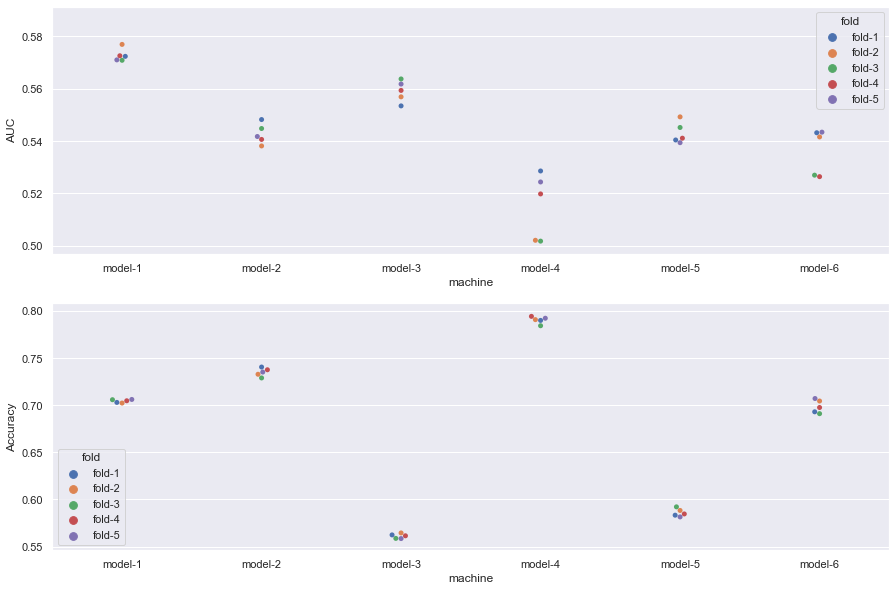

In [70]:
plot_results(toplot_result)

In [71]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,neighbors,rate_aug,sample_aug
2,machine-3,8,1.0,0.7


In [72]:
weight_data = train_section_3_aug[train_section_3_aug.target.isin([0,1])]

In [73]:
weighted_section_3_model = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = weight_data, trained_model = weighted_section_3_model)

In [74]:
roc_auc_score(weight_data.target.values,result)

0.7160511513150366

#### Section 3: Random Forest

In [114]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450],
    'max_depth' : [15, 20, 35, 20, 10, 45],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35 ], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [115]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_3_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [116]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

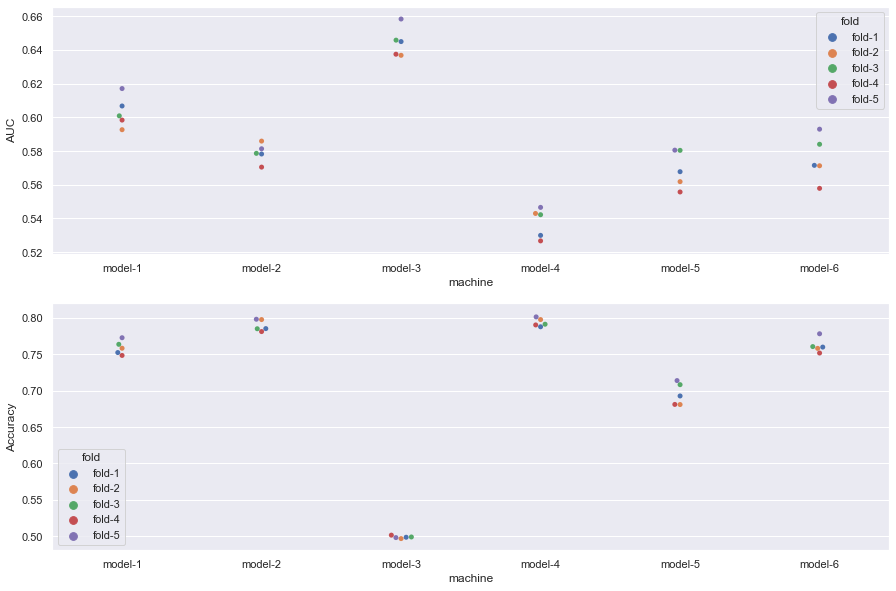

In [117]:
plot_results(toplot_result)

In [118]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.7


### Testing

testing with three section Random forest

bagging and consolidation with logistic regression

In [75]:
validation_dataset = validation_dataset[ ['target'] + numerical_features]
validation_dataset_distance = compute_mahalanobis_parts(validation_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
validation_dataset_scaled = scaler(validation_dataset_distance, scalerx)

In [76]:
validation_section_1, validation_section_2, validation_section_3 = partitions(validation_dataset_scaled)

In [91]:
target_vector = np.concatenate((validation_section_1.target.values, validation_section_2.target.values, validation_section_3.target.values), axis=None)

testing with KNN

In [84]:
predictions_val_section1 = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = validation_section_1, trained_model = weighted_section_1_model)
predictions_val_section2 = weighting_models(models = modelsTrained_section_2 , features = features_to_use, data = validation_section_2, trained_model = weighted_section_2_model)
predictions_val_section3 = weighting_models(models = modelsTrained_section_3 , features = features_to_use, data = validation_section_3, trained_model = weighted_section_3_model)
vector_predictions = np.concatenate((predictions_val_section1, predictions_val_section2, predictions_val_section3), axis=None)

In [92]:
roc_auc_score(target_vector, vector_predictions)

0.6474356824262131

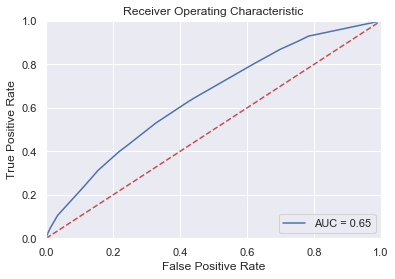

In [100]:
fpr, tpr, threshold = roc_curve(target_vector, vector_predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [117]:
def reconstructing_data(list_data, list_predictions, threshold = 0.15 ):
    list_data_result = list()
    for data,vector in zip(list_data, list_predictions):
        data['target'] = np.where(vector > threshold, 1,0)
        list_data_result.append(data)
    return pd.concat(list_data_result).sort_index()

In [118]:
result_validation = reconstructing_data([validation_section_1, validation_section_2, validation_section_3], [predictions_val_section1, predictions_val_section2, predictions_val_section3])

In [119]:
result_validation.head()

,target,var_4,var_12,var_46,var_78,var_81,var_110,var_152,var_175,var_183,var_199,mahalanobis
0,0,0.316356,-1.508938,-0.052114,0.991112,-0.566750,1.704601,0.529051,-1.552655,0.961559,-0.394131,0.097856
1,0,0.547758,-0.665887,-0.065743,1.166426,-0.501709,0.793949,1.329829,0.363195,0.104885,0.913032,-1.087022
2,0,0.784832,-0.189335,-0.089332,-1.417152,-0.261905,0.469365,0.515881,1.674753,0.508151,0.412824,-0.898535
3,0,-0.309164,1.031272,-0.225729,-0.655046,2.067391,-0.157721,0.434366,-1.216692,0.766577,-0.010791,-0.481836
4,0,-0.105631,0.688470,0.593702,-0.615033,0.564877,2.033481,0.816830,0.090682,1.100095,-0.537944,-0.541638


### Conclusions

* Run only Random Forest , why??
   * fast execution time
   * not bad AUC
* then go further with hiper parameter tunning